In [ ]:
!pip install opencv-python
!pip install imutils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/ML team project/Project 2/Neubauer Chamber Automation

!pip install import-ipynb

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/12swurGjFVTSgi6fpziRcJ-tqsj6OoBgK/ML team project/Project 2/Neubauer Chamber Automation
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=245763acc9d86b9488cdd297f69f93d0dbc050e70c629e8512db8490b10f8b47
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [ ]:
import numpy as np
import cv2
import imutils
import time
import pandas as pd
import os

import torch
import torch.nn as nn
from torchvision.transforms import Resize
import matplotlib.pyplot as plt

import import_ipynb
from UNetModel import UNet

importing Jupyter notebook from UNetModel.ipynb


In [ ]:
def manual_square(img, output_path, img_name):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    low_red = np.array([161, 155, 84])
    high_red = np.array([179, 255, 255])
    red_mask = cv2.inRange(hsv, low_red, high_red)
    
    pixels = cv2.countNonZero(red_mask)
    num_ref_tot=(img.shape[0]*img.shape[1])/pixels
    
    #take away 1 since the annotation covers 1 square
    return np.round(num_ref_tot,2) - 1

In [ ]:
start = time.time()

basepath_input = 'Data Set/Square Detection/Cropped-augmented-norotation/'
basepath_output= 'Data Set/Square Detection/Results/'
excel_file_df = pd.DataFrame([], columns=['filename', 'total squares fitted'])
for i_item, item in enumerate(os.listdir(basepath_input)):

    if os.path.isfile(os.path.join(basepath_input, item)):
        
        img = cv2.imread(os.path.join(basepath_input, item))
        img_name=item.split('.')[0]
        result=manual_square(img, basepath_output, img_name)
        
        print('Number of reference squares fit in '+img_name+' : ', result)
        excel_file_df.loc[len(excel_file_df)]= [item, result]


timestr = time.strftime("%Y%m%d-%H%M%S")
excel_file_df.to_excel(basepath_output+"squares_summary_{}.xlsx".format(timestr))               
end = time.time()
print('Number of images processed: ', i_item+1, '\nTotal time: ', end - start, 'seconds')

Number of reference squares fit in 2 :  47.09
Number of reference squares fit in 12 :  49.36
Number of reference squares fit in 26 :  4.61
Number of reference squares fit in 34 :  35.31
Number of reference squares fit in 4 :  27.37


FileNotFoundError: ignored

In [ ]:
state_dict = torch.load('models/unet2_bilinear_CombinedLoss.pt', map_location=torch.device('cpu'))['model_state_dict']
model = UNet(3,2)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
def count_cells(image, mask, thresh=1):
    #Get contours
    contours,hierarchy = cv2.findContours(mask, 1, 2)

    out = image.copy()
    coords = []
    for cnt in contours:
        #Find minimum enclosing circle
        (x,y),radius = cv2.minEnclosingCircle(cnt)
        if radius < thresh:
            continue
        center = (int(x),int(y))
        radius = int(radius)
        coords.append([int(x), int(y), radius])
        #Annotate and return
        cv2.circle(out,center,radius,(0,255,0),2)

    return out, np.array(coords)

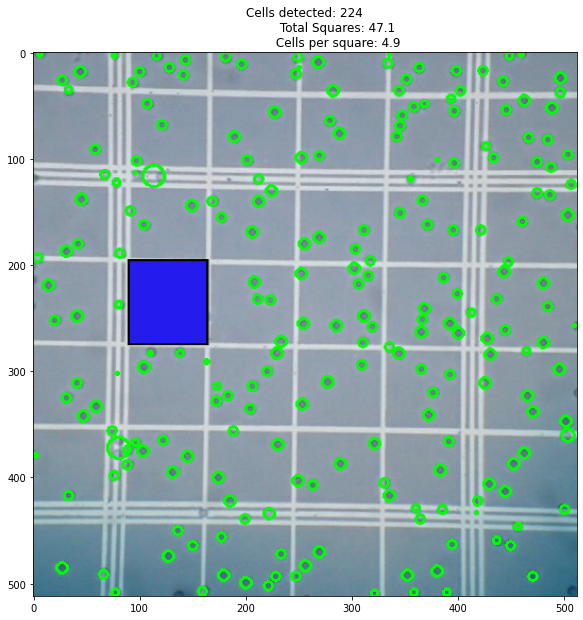

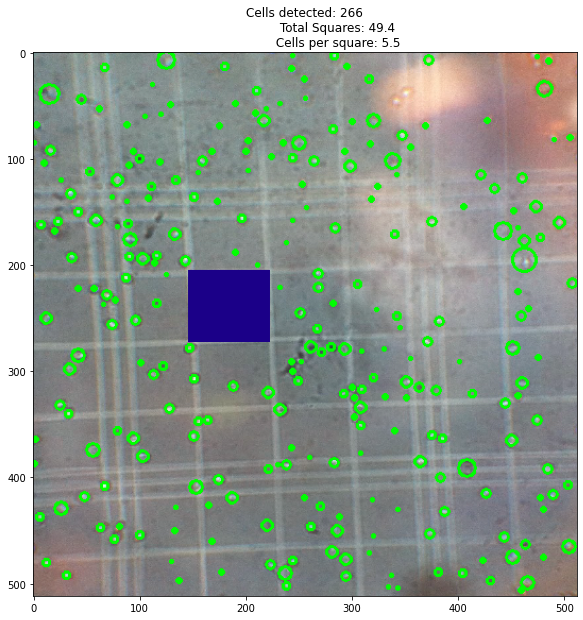

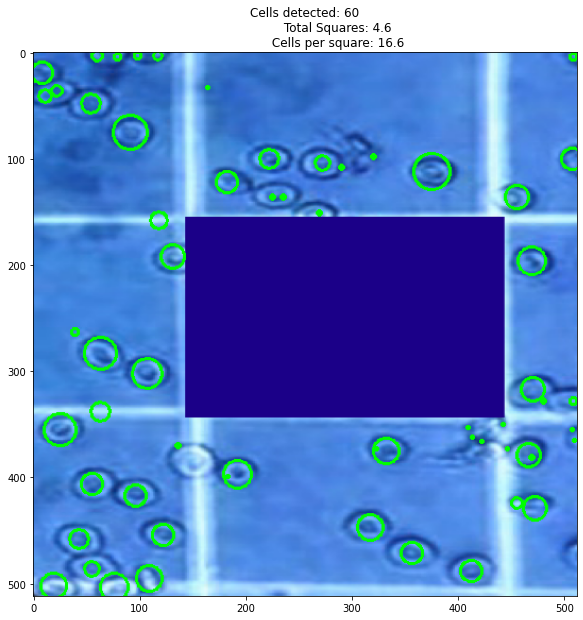

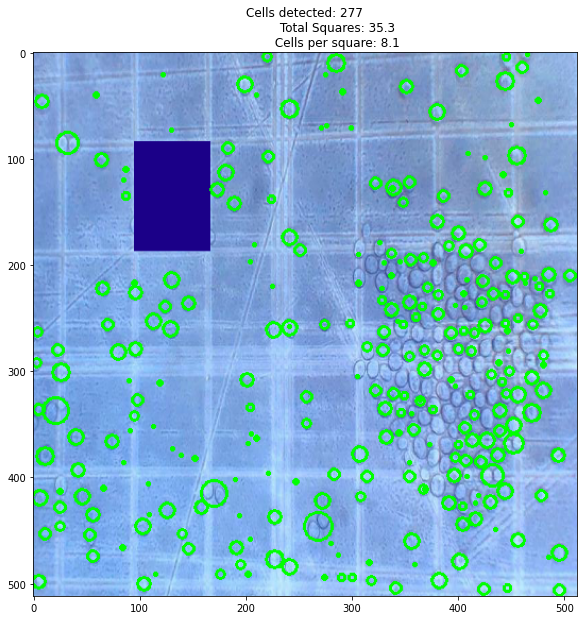

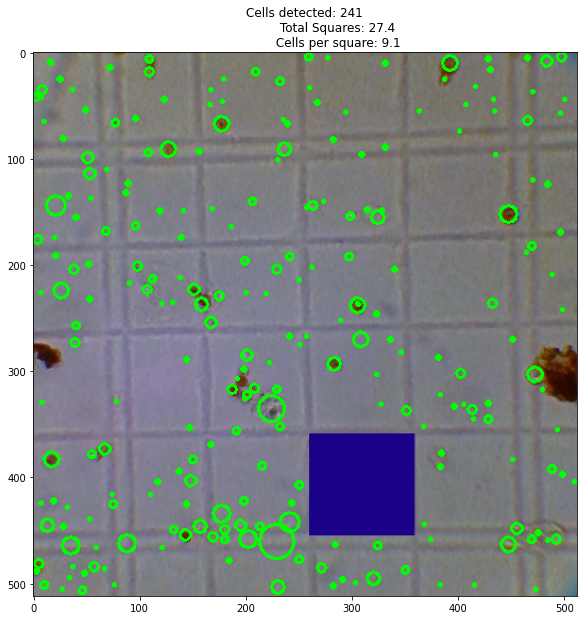

In [ ]:
image_names = os.listdir(basepath_input)
predicted_masks = []
for file in image_names:
    original_im = cv2.imread(basepath_input+file)
    #Resize for model
    im = original_im/255.0
    im = torch.from_numpy(im.astype('float32')).transpose(2,0).unsqueeze(0)
    im = Resize((512,512))(im)
    
    #Get predictions
    mask = model(im).detach().argmax(dim=1)
    mask = (mask*255).numpy().astype('uint8')[0]

    #Get image to correct shape and type
    im = im[0].transpose(2,0).transpose(1,0).numpy()
    im = (im*255).astype('uint8')

    annotated_im, coords = count_cells(im, mask)
    cell_count = len(coords)
    
    #Get cell concentration per square
    square_count = manual_square(original_im, '', '')
    concentration = cell_count/(square_count)
    
    plt.figure(figsize=(10,10))
    plt.imshow(annotated_im)
    plt.title(f'Cells detected: {cell_count}\nTotal Squares: {square_count:.1f}\nCells per square: {concentration:.1f}')
    
